In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 23)
(709325, 20)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
use_features = pp.get_feature_list()
use_features

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat']

In [8]:
# records of last 2 years
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(68919, 13)

In [14]:
monthly_volume = int(df_track.shape[0] / 24)
df_track.head()

,num_bed,sqft_zip_avg,num_bath,view,date,sold_price,pool,lon,lat,impr_over_land,sqft_price_zip_avg,sold_price_zip_avg,sqft
1,5.0,2074.092577,3.0,1,2015-10-01,635000,1,-116.87829,33.05136,1.822222,221.650542,442844.453711,2812
68743,3.0,1585.002513,3.0,0,2015-10-01,255000,0,-116.92729,32.88099,1.469388,250.745394,389755.862647,1908
68199,4.0,2171.954044,2.0,0,2015-10-01,635000,1,-116.81683,32.83643,1.819159,242.273897,500043.198529,2711
21429,2.0,1937.828889,2.0,1,2015-10-01,925000,1,-116.98197,32.76496,0.111355,282.771111,520922.222222,2833
67755,4.0,2605.547297,2.0,1,2015-10-01,570000,0,-117.00732,33.28106,2.160035,209.511261,516299.549550,2630


### LinearRegression

In [19]:
# walk-forward validation
# K-fold cross validation
from sklearn.linear_model import Ridge
rr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ElasticNet(random_state=42))
     ])
parameters = {'clf__l1_ratio': [0.05, 0.07, 0.1, 0.12, 0.14],
              'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09]}

mm = ModelManager(df_track, use_features, rr, time_series=True)
mm.run(param_grid=parameters, sliding_window=monthly_volume*12, test_size=monthly_volume*4, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] track/sliding/test window size: 57435, 34452, 11484
[dp] train/valid/test size: 45948, 11487, 11484
[dp] walk-forward train:(11487,), test:(11487,)
[dp] walk-forward train:(22974,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] 4-fold walk-forward validation
[dp] track_window:57435, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished


174609.55013747595

In [20]:
mm.summary()

[dp] best params: {'clf__alpha': 0.01, 'clf__l1_ratio': 0.14}
[dp] best score: -29800533719.24541
[dp] cv results:
{'mean_fit_time': array([0.33927679, 0.51273865, 0.49857473, 0.55121511, 0.58969176,
       0.34867769, 0.38514906, 0.34090728, 0.35632187, 0.40520227,
       0.245152  , 0.27009356, 0.27460539, 0.25154299, 0.21933359,
       0.18085742, 0.20479423, 0.21306634, 0.18499184, 0.17960328,
       0.19464308, 0.17321092, 0.1893785 , 0.14262927, 0.08823448]),
 'mean_score_time': array([0.00250727, 0.00313383, 0.00300831, 0.00300723, 0.00338477,
       0.00288224, 0.00351   , 0.00313324, 0.00392026, 0.00325954,
       0.00313491, 0.00288343, 0.00313413, 0.00288361, 0.0027582 ,
       0.00288326, 0.00288343, 0.00275844, 0.00250655, 0.00300813,
       0.00288296, 0.00288332, 0.00263232, 0.00275731, 0.00238162]),
 'mean_test_score': array([-2.98058033e+10, -2.98046252e+10, -2.98028657e+10, -2.98016977e+10,
       -2.98005337e+10, -2.99362289e+10, -2.99315506e+10, -2.99245994e+10,
   

[dp] training error: 173985.06033448342
[dp] testing error: 174609.55013747595


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [17]:
ntrees = np.arange(20,110,40)
depths = np.arange(7,15)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}
rf = RandomForestRegressor(n_jobs=-1, random_state=17)

mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(param_grid=parameters, sliding_window=monthly_volume*12, test_size=monthly_volume*4, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] track/sliding/test window size: 57435, 34452, 11484
[dp] train/valid/test size: 45948, 11487, 11484
[dp] walk-forward train:(11487,), test:(11487,)
[dp] walk-forward train:(22974,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] 4-fold walk-forward validation
[dp] track_window:57435, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.7min finished


128640.23095298899

In [18]:
mm.summary()

[dp] best params: {'max_depth': 14, 'n_estimators': 100}
[dp] best score: -16140822618.666355
[dp] cv results:
{'mean_fit_time': array([0.66465616, 2.59790021, 4.11757374, 1.86345631, 3.27765191,
       5.85299504, 1.94549471, 3.26983947, 5.85949248, 2.1790936 ,
       4.22987425, 7.66555792, 2.57839781, 4.43433255, 7.21107447,
       2.41967285, 4.77435797, 7.8002997 , 2.34006107, 4.83725309,
       8.73259884, 2.9677586 , 5.5669294 , 8.33683133]),
 'mean_score_time': array([0.3476873 , 0.78132409, 1.00399959, 0.73053652, 0.56255287,
       0.96493262, 0.67193907, 1.05087918, 1.02601987, 0.71761954,
       0.8808133 , 1.04873049, 1.01774144, 0.79921544, 0.96323478,
       0.76684922, 0.96331495, 1.20829332, 0.97274745, 1.0343135 ,
       1.40586239, 1.10372186, 1.01571923, 0.95253152]),
 'mean_test_score': array([-1.97659020e+10, -1.94825749e+10, -1.94393517e+10, -1.86629973e+10,
       -1.83652998e+10, -1.82843815e+10, -1.78667247e+10, -1.75738486e+10,
       -1.75089142e+10, -1.7429

[dp] training error: 94459.05164322391
[dp] testing error: 128640.23095298899


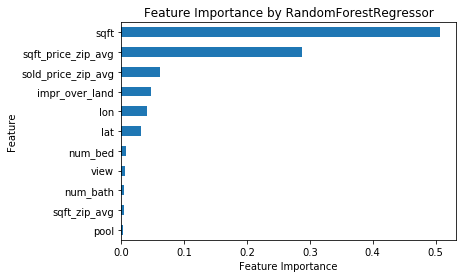

In [19]:
mm.plot_feature_importance()

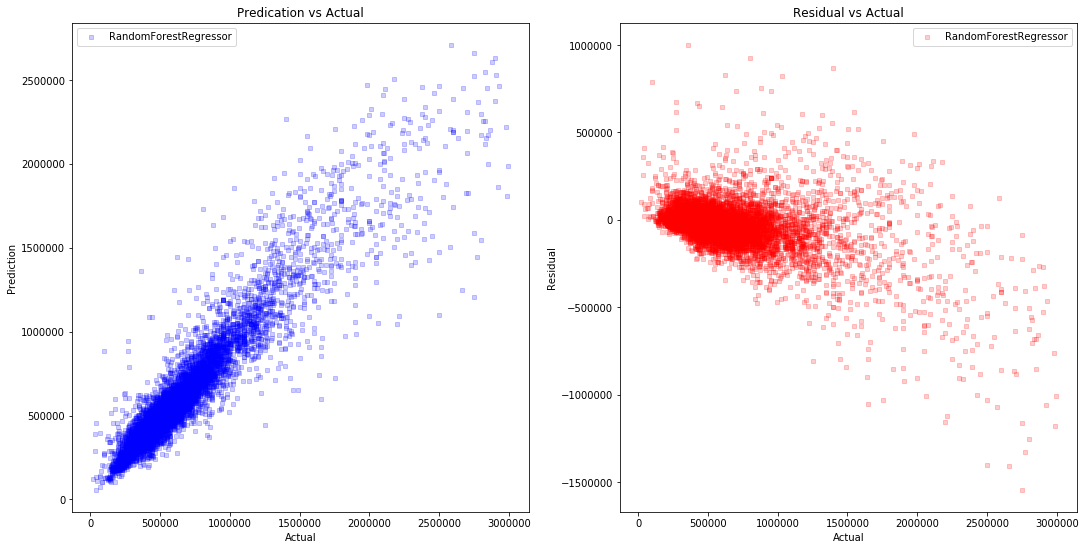

In [20]:
mm.plot_residual()

C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


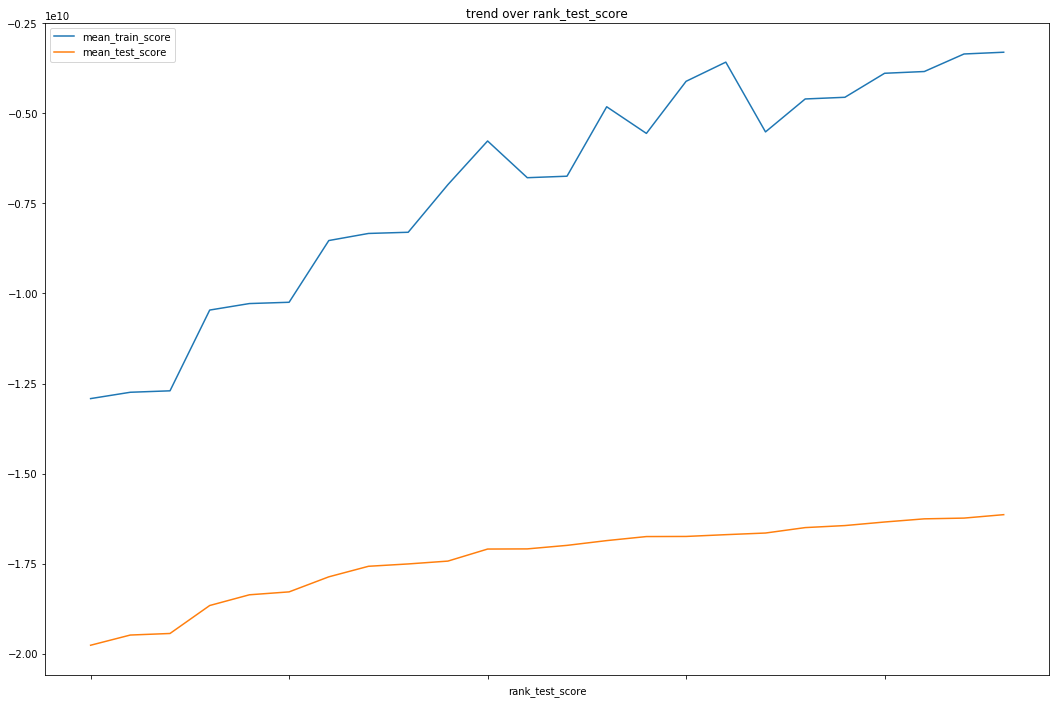

[{'max_depth': 7, 'n_estimators': 20},
 {'max_depth': 7, 'n_estimators': 60},
 {'max_depth': 7, 'n_estimators': 100},
 {'max_depth': 8, 'n_estimators': 20},
 {'max_depth': 8, 'n_estimators': 60},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 9, 'n_estimators': 20},
 {'max_depth': 9, 'n_estimators': 60},
 {'max_depth': 9, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 60},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 12, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 60},
 {'max_depth': 13, 'n_estimators': 20},
 {'max_depth': 14, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 100},
 {'max_depth': 12, 'n_estimators': 60},
 {'max_depth': 12, 'n_estimators': 100},
 {'max_depth': 13, 'n_estimators': 60},
 {'max_depth': 13, 'n_estimators': 100},
 {'max_depth': 14, 'n_estimators': 60},
 {'max_depth': 14, 'n_estimators': 100}]

In [21]:
mm.plot_learning_curve()

### residual analysis
* check distribution of residual
* scatter plot of residual and attributes: sqrt, lon, lat to see any correlation

In [34]:
df_check = mm.X_test.copy(deep=True)
df_check['sold_price'] = mm.y_test
df_check['predict'] = mm.y_predict
df_check['residual'] = mm.residual

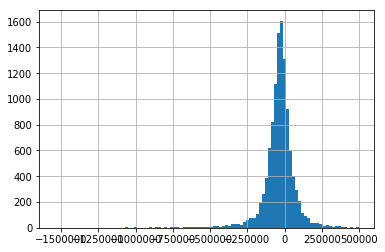

In [32]:
df_check[df_check['residual']<500000]['residual'].hist(bins=100)

Text(0.5,1,'sold_price vs residual')

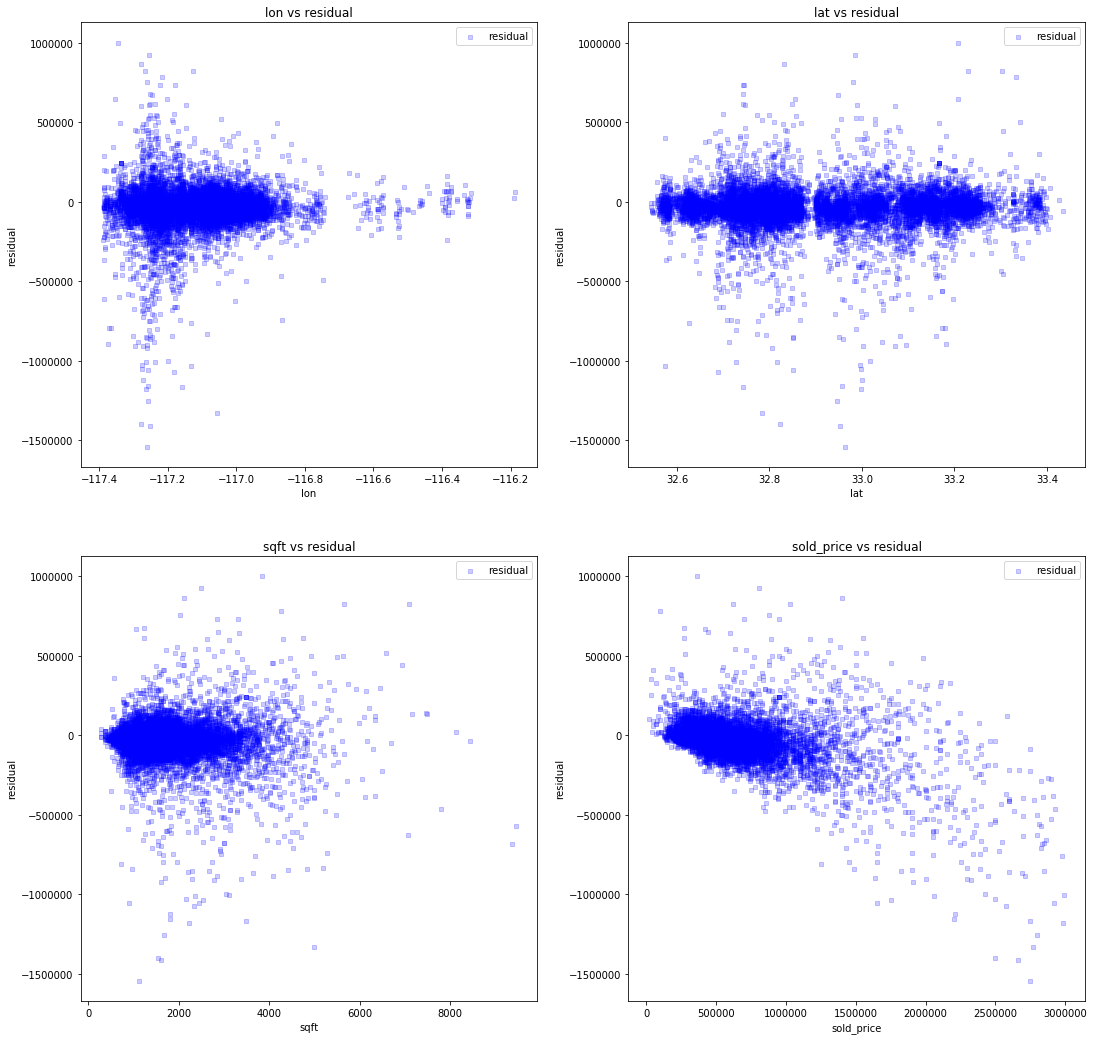

In [33]:
fig = plt.figure(figsize=(18, 18))
ax1 = fig.add_subplot(221)
ax1.scatter(df_check['lon'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('lon')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('lon vs residual')

ax1 = fig.add_subplot(222)
ax1.scatter(df_check['lat'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('lat')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('lat vs residual')

ax1 = fig.add_subplot(223)
ax1.scatter(df_check['sqft'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('sqft')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('sqft vs residual')

ax1 = fig.add_subplot(224)
ax1.scatter(df_check['sold_price'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('sold_price')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('sold_price vs residual')